In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 512)               424448    


 dense_1 (Dense)             (None, 256)               131328    


 dense_2 (Dense)             (None, 128)               32896     


 dense_3 (Dense)             (None, 1)                 129       


Total params: 588801 (2.25 MB)


Trainable params: 588801 (2.25 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:13 - loss: 0.0548 - STD: 6.9625e-04 - MAE: 0.2168

 4/64 [>.............................] - ETA: 1s - loss: 0.0246 - STD: 0.0014 - MAE: 0.1221      

 5/64 [=>............................] - ETA: 1s - loss: 0.0243 - STD: 0.0014 - MAE: 0.1212

 6/64 [=>............................] - ETA: 2s - loss: 0.0244 - STD: 0.0013 - MAE: 0.1218

 7/64 [==>...........................] - ETA: 2s - loss: 0.0244 - STD: 0.0013 - MAE: 0.1222

 8/64 [==>...........................] - ETA: 2s - loss: 0.0244 - STD: 0.0013 - MAE: 0.1222

 9/64 [===>..........................] - ETA: 2s - loss: 0.0242 - STD: 0.0013 - MAE: 0.1218

10/64 [===>..........................] - ETA: 2s - loss: 0.0239 - STD: 0.0013 - MAE: 0.1204

11/64 [====>.........................] - ETA: 2s - loss: 0.0233 - STD: 0.0013 - MAE: 0.1185

12/64 [====>.........................] - ETA: 2s - loss: 0.0226 - STD: 0.0013 - MAE: 0.1160

13/64 [=====>........................] - ETA: 2s - loss: 0.0219 - STD: 0.0013 - MAE: 0.1132

14/64 [=====>........................] - ETA: 2s - loss: 0.0210 - STD: 0.0014 - MAE: 0.1105

15/64 [======>.......................] - ETA: 2s - loss: 0.0203 - STD: 0.0014 - MAE: 0.1083

16/64 [======>.......................] - ETA: 2s - loss: 0.0197 - STD: 0.0015 - MAE: 0.1068

17/64 [======>.......................] - ETA: 3s - loss: 0.0196 - STD: 0.0015 - MAE: 0.1060

21/64 [========>.....................] - ETA: 2s - loss: 0.0183 - STD: 0.0018 - MAE: 0.1045

22/64 [=========>....................] - ETA: 2s - loss: 0.0179 - STD: 0.0019 - MAE: 0.1036

23/64 [=========>....................] - ETA: 2s - loss: 0.0176 - STD: 0.0019 - MAE: 0.1025

24/64 [==========>...................] - ETA: 2s - loss: 0.0172 - STD: 0.0020 - MAE: 0.1014

25/64 [==========>...................] - ETA: 2s - loss: 0.0169 - STD: 0.0020 - MAE: 0.1003

26/64 [===========>..................] - ETA: 2s - loss: 0.0167 - STD: 0.0021 - MAE: 0.0994

27/64 [===========>..................] - ETA: 2s - loss: 0.0164 - STD: 0.0021 - MAE: 0.0985

28/64 [============>.................] - ETA: 2s - loss: 0.0162 - STD: 0.0021 - MAE: 0.0977

29/64 [============>.................] - ETA: 2s - loss: 0.0160 - STD: 0.0022 - MAE: 0.0969

30/64 [=============>................] - ETA: 2s - loss: 0.0159 - STD: 0.0022 - MAE: 0.0962

31/64 [=============>................] - ETA: 2s - loss: 0.0157 - STD: 0.0023 - MAE: 0.0955

32/64 [==============>...............] - ETA: 2s - loss: 0.0155 - STD: 0.0023 - MAE: 0.0948

33/64 [==============>...............] - ETA: 1s - loss: 0.0153 - STD: 0.0024 - MAE: 0.0943

34/64 [==============>...............] - ETA: 1s - loss: 0.0151 - STD: 0.0024 - MAE: 0.0937

35/64 [===============>..............] - ETA: 1s - loss: 0.0150 - STD: 0.0025 - MAE: 0.0932

36/64 [===============>..............] - ETA: 1s - loss: 0.0148 - STD: 0.0026 - MAE: 0.0928

37/64 [================>.............] - ETA: 1s - loss: 0.0147 - STD: 0.0026 - MAE: 0.0925

38/64 [================>.............] - ETA: 1s - loss: 0.0146 - STD: 0.0027 - MAE: 0.0922

39/64 [=================>............] - ETA: 1s - loss: 0.0144 - STD: 0.0028 - MAE: 0.0919

40/64 [=================>............] - ETA: 1s - loss: 0.0143 - STD: 0.0029 - MAE: 0.0917

41/64 [==================>...........] - ETA: 1s - loss: 0.0142 - STD: 0.0029 - MAE: 0.0914

42/64 [==================>...........] - ETA: 1s - loss: 0.0141 - STD: 0.0030 - MAE: 0.0912

43/64 [===================>..........] - ETA: 1s - loss: 0.0140 - STD: 0.0031 - MAE: 0.0908

44/64 [===================>..........] - ETA: 1s - loss: 0.0139 - STD: 0.0032 - MAE: 0.0905

45/64 [====================>.........] - ETA: 1s - loss: 0.0138 - STD: 0.0032 - MAE: 0.0902

46/64 [====================>.........] - ETA: 1s - loss: 0.0137 - STD: 0.0033 - MAE: 0.0899

47/64 [=====================>........] - ETA: 1s - loss: 0.0136 - STD: 0.0034 - MAE: 0.0895

48/64 [=====================>........] - ETA: 0s - loss: 0.0135 - STD: 0.0035 - MAE: 0.0892

49/64 [=====================>........] - ETA: 0s - loss: 0.0134 - STD: 0.0035 - MAE: 0.0889

50/64 [======================>.......] - ETA: 0s - loss: 0.0134 - STD: 0.0036 - MAE: 0.0886

51/64 [======================>.......] - ETA: 0s - loss: 0.0133 - STD: 0.0037 - MAE: 0.0884

52/64 [=======================>......] - ETA: 0s - loss: 0.0132 - STD: 0.0038 - MAE: 0.0881

53/64 [=======================>......] - ETA: 0s - loss: 0.0131 - STD: 0.0039 - MAE: 0.0879

54/64 [========================>.....] - ETA: 0s - loss: 0.0131 - STD: 0.0040 - MAE: 0.0877

55/64 [========================>.....] - ETA: 0s - loss: 0.0130 - STD: 0.0041 - MAE: 0.0875

56/64 [=========================>....] - ETA: 0s - loss: 0.0129 - STD: 0.0042 - MAE: 0.0873

57/64 [=========================>....] - ETA: 0s - loss: 0.0129 - STD: 0.0043 - MAE: 0.0871

58/64 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 0.0044 - MAE: 0.0870

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 0.0045 - MAE: 0.0868

60/64 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 0.0046 - MAE: 0.0866

61/64 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 0.0047 - MAE: 0.0864

62/64 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.0049 - MAE: 0.0862

63/64 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 0.0050 - MAE: 0.0860

64/64 [==============================] - ETA: 0s - loss: 0.0124 - STD: 0.0051 - MAE: 0.0859

64/64 [==============================] - 6s 72ms/step - loss: 0.0124 - STD: 0.0051 - MAE: 0.0859 - val_loss: 0.0085 - val_STD: 0.0096 - val_MAE: 0.0724


Epoch 2/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0090 - STD: 0.0131 - MAE: 0.0736

 2/64 [..............................] - ETA: 4s - loss: 0.0092 - STD: 0.0134 - MAE: 0.0741

 3/64 [>.............................] - ETA: 3s - loss: 0.0091 - STD: 0.0136 - MAE: 0.0740

 4/64 [>.............................] - ETA: 3s - loss: 0.0091 - STD: 0.0139 - MAE: 0.0740

 5/64 [=>............................] - ETA: 3s - loss: 0.0090 - STD: 0.0142 - MAE: 0.0740

 6/64 [=>............................] - ETA: 3s - loss: 0.0090 - STD: 0.0145 - MAE: 0.0740

 7/64 [==>...........................] - ETA: 3s - loss: 0.0090 - STD: 0.0148 - MAE: 0.0741

 8/64 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.0152 - MAE: 0.0741

 9/64 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0155 - MAE: 0.0741

10/64 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0158 - MAE: 0.0742

11/64 [====>.........................] - ETA: 3s - loss: 0.0089 - STD: 0.0161 - MAE: 0.0742

12/64 [====>.........................] - ETA: 3s - loss: 0.0088 - STD: 0.0164 - MAE: 0.0742

13/64 [=====>........................] - ETA: 2s - loss: 0.0088 - STD: 0.0167 - MAE: 0.0742

14/64 [=====>........................] - ETA: 2s - loss: 0.0088 - STD: 0.0170 - MAE: 0.0741

15/64 [======>.......................] - ETA: 2s - loss: 0.0088 - STD: 0.0173 - MAE: 0.0740

16/64 [======>.......................] - ETA: 2s - loss: 0.0088 - STD: 0.0176 - MAE: 0.0739

17/64 [======>.......................] - ETA: 2s - loss: 0.0088 - STD: 0.0179 - MAE: 0.0738

18/64 [=======>......................] - ETA: 2s - loss: 0.0088 - STD: 0.0182 - MAE: 0.0737

19/64 [=======>......................] - ETA: 2s - loss: 0.0087 - STD: 0.0185 - MAE: 0.0736

20/64 [========>.....................] - ETA: 2s - loss: 0.0087 - STD: 0.0188 - MAE: 0.0736

21/64 [========>.....................] - ETA: 2s - loss: 0.0087 - STD: 0.0192 - MAE: 0.0735

22/64 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0195 - MAE: 0.0735

23/64 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0198 - MAE: 0.0735

24/64 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0202 - MAE: 0.0734

25/64 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0205 - MAE: 0.0734

26/64 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.0208 - MAE: 0.0734

27/64 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0212 - MAE: 0.0734

29/64 [============>.................] - ETA: 1s - loss: 0.0086 - STD: 0.0218 - MAE: 0.0732

30/64 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 0.0221 - MAE: 0.0731

31/64 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 0.0224 - MAE: 0.0731

32/64 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 0.0227 - MAE: 0.0730

33/64 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 0.0230 - MAE: 0.0730

34/64 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 0.0233 - MAE: 0.0730

35/64 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 0.0236 - MAE: 0.0729

36/64 [===============>..............] - ETA: 1s - loss: 0.0086 - STD: 0.0240 - MAE: 0.0729

37/64 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0243 - MAE: 0.0728

38/64 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0246 - MAE: 0.0728

39/64 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0248 - MAE: 0.0727

40/64 [=================>............] - ETA: 1s - loss: 0.0085 - STD: 0.0251 - MAE: 0.0727

41/64 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0254 - MAE: 0.0726

42/64 [==================>...........] - ETA: 1s - loss: 0.0085 - STD: 0.0257 - MAE: 0.0726

43/64 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.0259 - MAE: 0.0725

44/64 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.0262 - MAE: 0.0724

45/64 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.0264 - MAE: 0.0724

46/64 [====================>.........] - ETA: 1s - loss: 0.0085 - STD: 0.0266 - MAE: 0.0723

47/64 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.0269 - MAE: 0.0723

48/64 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.0271 - MAE: 0.0723

49/64 [=====================>........] - ETA: 0s - loss: 0.0084 - STD: 0.0273 - MAE: 0.0722

50/64 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.0276 - MAE: 0.0722

51/64 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.0278 - MAE: 0.0721

52/64 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0280 - MAE: 0.0721

53/64 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.0282 - MAE: 0.0720

54/64 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0284 - MAE: 0.0720

55/64 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0285 - MAE: 0.0720

56/64 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.0287 - MAE: 0.0719

57/64 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.0289 - MAE: 0.0718

58/64 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0290 - MAE: 0.0718

59/64 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0292 - MAE: 0.0718

60/64 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0294 - MAE: 0.0717

61/64 [===========================>..] - ETA: 0s - loss: 0.0083 - STD: 0.0295 - MAE: 0.0717

62/64 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.0297 - MAE: 0.0717

63/64 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.0298 - MAE: 0.0716

64/64 [==============================] - ETA: 0s - loss: 0.0083 - STD: 0.0300 - MAE: 0.0716

64/64 [==============================] - 4s 60ms/step - loss: 0.0083 - STD: 0.0300 - MAE: 0.0716 - val_loss: 0.0074 - val_STD: 0.0275 - val_MAE: 0.0671


Epoch 3/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0077 - STD: 0.0391 - MAE: 0.0689

 2/64 [..............................] - ETA: 3s - loss: 0.0078 - STD: 0.0390 - MAE: 0.0690

 3/64 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.0389 - MAE: 0.0693

 4/64 [>.............................] - ETA: 3s - loss: 0.0079 - STD: 0.0389 - MAE: 0.0693

 5/64 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.0390 - MAE: 0.0693

 6/64 [=>............................] - ETA: 3s - loss: 0.0079 - STD: 0.0391 - MAE: 0.0693

 7/64 [==>...........................] - ETA: 3s - loss: 0.0079 - STD: 0.0392 - MAE: 0.0693

 8/64 [==>...........................] - ETA: 3s - loss: 0.0078 - STD: 0.0392 - MAE: 0.0691

 9/64 [===>..........................] - ETA: 3s - loss: 0.0078 - STD: 0.0393 - MAE: 0.0690

10/64 [===>..........................] - ETA: 3s - loss: 0.0078 - STD: 0.0393 - MAE: 0.0690

11/64 [====>.........................] - ETA: 3s - loss: 0.0078 - STD: 0.0392 - MAE: 0.0689

12/64 [====>.........................] - ETA: 3s - loss: 0.0078 - STD: 0.0393 - MAE: 0.0688

13/64 [=====>........................] - ETA: 3s - loss: 0.0078 - STD: 0.0393 - MAE: 0.0688

14/64 [=====>........................] - ETA: 2s - loss: 0.0078 - STD: 0.0393 - MAE: 0.0687

15/64 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0394 - MAE: 0.0687

16/64 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0395 - MAE: 0.0686

17/64 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0396 - MAE: 0.0686

18/64 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.0396 - MAE: 0.0686

19/64 [=======>......................] - ETA: 2s - loss: 0.0077 - STD: 0.0397 - MAE: 0.0686

20/64 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.0397 - MAE: 0.0685

22/64 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.0398 - MAE: 0.0685

23/64 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.0398 - MAE: 0.0684

24/64 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.0399 - MAE: 0.0683

25/64 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.0399 - MAE: 0.0683

26/64 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0400 - MAE: 0.0682

27/64 [===========>..................] - ETA: 2s - loss: 0.0077 - STD: 0.0400 - MAE: 0.0682

28/64 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.0401 - MAE: 0.0681

29/64 [============>.................] - ETA: 1s - loss: 0.0076 - STD: 0.0402 - MAE: 0.0681

30/64 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.0402 - MAE: 0.0680

31/64 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.0403 - MAE: 0.0679

32/64 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0403 - MAE: 0.0679

33/64 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0404 - MAE: 0.0678

34/64 [==============>...............] - ETA: 1s - loss: 0.0076 - STD: 0.0404 - MAE: 0.0677

35/64 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0405 - MAE: 0.0677

36/64 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.0406 - MAE: 0.0676

37/64 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0406 - MAE: 0.0676

38/64 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0407 - MAE: 0.0675

39/64 [=================>............] - ETA: 1s - loss: 0.0075 - STD: 0.0407 - MAE: 0.0674

40/64 [=================>............] - ETA: 1s - loss: 0.0075 - STD: 0.0408 - MAE: 0.0674

41/64 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0409 - MAE: 0.0673

42/64 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0409 - MAE: 0.0672

43/64 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.0410 - MAE: 0.0671

44/64 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0411 - MAE: 0.0671

45/64 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0412 - MAE: 0.0670

46/64 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0412 - MAE: 0.0669

47/64 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0413 - MAE: 0.0668

48/64 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0414 - MAE: 0.0668

49/64 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.0415 - MAE: 0.0667

50/64 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0415 - MAE: 0.0666

51/64 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0416 - MAE: 0.0665

52/64 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0417 - MAE: 0.0665

53/64 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0418 - MAE: 0.0664

54/64 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0419 - MAE: 0.0663

55/64 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.0420 - MAE: 0.0662

56/64 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0421 - MAE: 0.0661

57/64 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.0422 - MAE: 0.0661

58/64 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0424 - MAE: 0.0660

59/64 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0425 - MAE: 0.0659

60/64 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0426 - MAE: 0.0659

61/64 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0427 - MAE: 0.0658

62/64 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0428 - MAE: 0.0657

63/64 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0430 - MAE: 0.0656

64/64 [==============================] - ETA: 0s - loss: 0.0072 - STD: 0.0431 - MAE: 0.0655

64/64 [==============================] - 4s 60ms/step - loss: 0.0072 - STD: 0.0431 - MAE: 0.0655 - val_loss: 0.0059 - val_STD: 0.0397 - val_MAE: 0.0592


Epoch 4/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0064 - STD: 0.0513 - MAE: 0.0604

 2/64 [..............................] - ETA: 3s - loss: 0.0064 - STD: 0.0518 - MAE: 0.0604

 3/64 [>.............................] - ETA: 3s - loss: 0.0063 - STD: 0.0524 - MAE: 0.0604

 4/64 [>.............................] - ETA: 3s - loss: 0.0063 - STD: 0.0526 - MAE: 0.0604

 5/64 [=>............................] - ETA: 3s - loss: 0.0063 - STD: 0.0529 - MAE: 0.0606

 6/64 [=>............................] - ETA: 3s - loss: 0.0063 - STD: 0.0532 - MAE: 0.0604

 7/64 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0533 - MAE: 0.0604

 8/64 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0536 - MAE: 0.0602

 9/64 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0537 - MAE: 0.0601

10/64 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0541 - MAE: 0.0601

11/64 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0543 - MAE: 0.0600

12/64 [====>.........................] - ETA: 3s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0599

13/64 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0547 - MAE: 0.0599

14/64 [=====>........................] - ETA: 2s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0598

15/64 [======>.......................] - ETA: 2s - loss: 0.0062 - STD: 0.0552 - MAE: 0.0597

16/64 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0596

17/64 [======>.......................] - ETA: 2s - loss: 0.0061 - STD: 0.0555 - MAE: 0.0595

18/64 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0557 - MAE: 0.0594

19/64 [=======>......................] - ETA: 2s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0594

20/64 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0593

21/64 [========>.....................] - ETA: 2s - loss: 0.0061 - STD: 0.0563 - MAE: 0.0593

22/64 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0564 - MAE: 0.0591

23/64 [=========>....................] - ETA: 2s - loss: 0.0061 - STD: 0.0565 - MAE: 0.0591

24/64 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0567 - MAE: 0.0590

25/64 [==========>...................] - ETA: 2s - loss: 0.0061 - STD: 0.0569 - MAE: 0.0590

26/64 [===========>..................] - ETA: 2s - loss: 0.0061 - STD: 0.0570 - MAE: 0.0590

27/64 [===========>..................] - ETA: 2s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0589

28/64 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0572 - MAE: 0.0589

29/64 [============>.................] - ETA: 2s - loss: 0.0060 - STD: 0.0574 - MAE: 0.0589

30/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0575 - MAE: 0.0588

31/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0575 - MAE: 0.0587

32/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0577 - MAE: 0.0587

33/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0578 - MAE: 0.0587

34/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0579 - MAE: 0.0586

35/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0579 - MAE: 0.0585

36/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0581 - MAE: 0.0585

37/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0582 - MAE: 0.0585

38/64 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0582 - MAE: 0.0584

39/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0583 - MAE: 0.0584

40/64 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0584 - MAE: 0.0583

41/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0585 - MAE: 0.0583

42/64 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0585 - MAE: 0.0583

43/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0586 - MAE: 0.0582

44/64 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0587 - MAE: 0.0582

45/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0588 - MAE: 0.0582

46/64 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0588 - MAE: 0.0581

47/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0589 - MAE: 0.0581

48/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0590 - MAE: 0.0580

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0590 - MAE: 0.0580

50/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0590 - MAE: 0.0580

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0591 - MAE: 0.0579

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0592 - MAE: 0.0579

53/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0592 - MAE: 0.0579

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0593 - MAE: 0.0578

55/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0593 - MAE: 0.0578

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0594 - MAE: 0.0577

57/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0595 - MAE: 0.0577

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0595 - MAE: 0.0577

59/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0596 - MAE: 0.0577

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0596 - MAE: 0.0576

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0597 - MAE: 0.0575

63/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0575

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0575

64/64 [==============================] - 4s 61ms/step - loss: 0.0058 - STD: 0.0598 - MAE: 0.0575 - val_loss: 0.0051 - val_STD: 0.0515 - val_MAE: 0.0541


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0056 - STD: 0.0614 - MAE: 0.0550

 2/64 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0553

 3/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0556

 4/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0629 - MAE: 0.0554

 5/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0627 - MAE: 0.0552

 6/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0552

 7/64 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0553

 8/64 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0552

 9/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0552

10/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0553

11/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0552

12/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0551

13/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0551

14/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0552

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0551

16/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0551

17/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0552

18/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0551

19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0550

20/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0550

21/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0549

22/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0548

23/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0548

24/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0548

25/64 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0548

26/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0547

27/64 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0548

28/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0547

29/64 [============>.................] - ETA: 2s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0547

30/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0547

31/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0547

32/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0546

33/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0546

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0545

36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0545

37/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0544

38/64 [================>.............] - ETA: 1s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0544

39/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0543

40/64 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0543

41/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0543

42/64 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0543

43/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0543

44/64 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0646 - MAE: 0.0542

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0543

46/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0542

47/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0542

48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0542

49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0541

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0648 - MAE: 0.0541

51/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0541

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0541

53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0540

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0540

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0540

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0540

57/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0539

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0540

59/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0539

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0539

61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0539

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0539

63/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0538

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0538

64/64 [==============================] - 4s 59ms/step - loss: 0.0052 - STD: 0.0653 - MAE: 0.0538 - val_loss: 0.0046 - val_STD: 0.0585 - val_MAE: 0.0514


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0522

 2/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0524

 3/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0527

 4/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0527

 5/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0525

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0524

 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0524

 8/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0524

 9/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0524

10/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0524

11/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0524

12/64 [====>.........................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0524

13/64 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0680 - MAE: 0.0524

14/64 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0679 - MAE: 0.0523

15/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0524

16/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0523

17/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0522

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0522

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0522

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0521

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0522

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0521

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0521

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0521

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0521

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0521

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0520

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0520

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0520

30/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0520

31/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0520

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0520

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0519

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0519

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0519

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0519

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0519

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0518

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0518

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0518

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0686 - MAE: 0.0518

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0518

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0517

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0517

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0517

47/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0517

48/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0517

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0517

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0517

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0518

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0518

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0518

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0518

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0518

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0518

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0518

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0517

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0518

64/64 [==============================] - 4s 61ms/step - loss: 0.0048 - STD: 0.0690 - MAE: 0.0518 - val_loss: 0.0044 - val_STD: 0.0603 - val_MAE: 0.0497


Epoch 7/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0675 - MAE: 0.0499

 2/64 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0679 - MAE: 0.0500

 4/64 [>.............................] - ETA: 2s - loss: 0.0047 - STD: 0.0689 - MAE: 0.0510

 5/64 [=>............................] - ETA: 2s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0512

 6/64 [=>............................] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0512

 7/64 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0509

 8/64 [==>...........................] - ETA: 2s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0510

 9/64 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0510

10/64 [===>..........................] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0510

11/64 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0511

12/64 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0510

13/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0510

14/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0510

15/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0510

16/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0510

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0509

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0509

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0510

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0509

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0509

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0510

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0510

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0510

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511

28/64 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0511

29/64 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0511

30/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0513

31/64 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0513

32/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0513

33/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0515

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0516

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0516

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0516

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0515

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0516

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0515

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0515

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0515

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0515

48/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0515

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0514

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0515

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0515

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0514

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0514

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0515

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0514

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0514

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0514

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0514

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0514

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0514

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0514

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0513

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0513

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0513

64/64 [==============================] - 4s 66ms/step - loss: 0.0048 - STD: 0.0701 - MAE: 0.0513 - val_loss: 0.0042 - val_STD: 0.0636 - val_MAE: 0.0494


Epoch 8/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0497

 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0494

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0496

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0498

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

12/64 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0498

13/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0498

14/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

15/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

30/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

31/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

33/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0500

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

48/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

64/64 [==============================] - 4s 64ms/step - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500 - val_loss: 0.0042 - val_STD: 0.0627 - val_MAE: 0.0485


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0706 - MAE: 0.0492

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

 3/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0501

 4/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

 5/64 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0497

 6/64 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0496

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0499

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0498

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0498

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0498

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0498

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0498

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

17/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

19/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0498

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

32/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

34/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0497

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

49/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

50/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0496

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0496

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

64/64 [==============================] - 5s 74ms/step - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495 - val_loss: 0.0041 - val_STD: 0.0671 - val_MAE: 0.0489


Epoch 10/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0044 - STD: 0.0756 - MAE: 0.0503

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0495

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0494

 4/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0497

 5/64 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0495

 6/64 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0498

 7/64 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0497

 8/64 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0496

 9/64 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0495

10/64 [===>..........................] - ETA: 4s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0495

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0495

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0495

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0495

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0495

16/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

17/64 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

18/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

19/64 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

20/64 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

21/64 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

33/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

34/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

35/64 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

36/64 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0494

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0494

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0494

48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

49/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

50/64 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0495

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0495

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0495

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496

64/64 [==============================] - 5s 75ms/step - loss: 0.0044 - STD: 0.0735 - MAE: 0.0496 - val_loss: 0.0042 - val_STD: 0.0624 - val_MAE: 0.0480


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0696 - MAE: 0.0490

 2/64 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0488

 3/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495

 4/64 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0493

 5/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

 6/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0495

 7/64 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0494

 8/64 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

 9/64 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0495

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

12/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0496

13/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

14/64 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0733 - MAE: 0.0497

16/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

17/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0498

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0499

19/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500

20/64 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500

21/64 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0501

22/64 [=========>....................] - ETA: 3s - loss: 0.0046 - STD: 0.0726 - MAE: 0.0502

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0502

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0730 - MAE: 0.0505

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0506

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0506

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0727 - MAE: 0.0511

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0724 - MAE: 0.0511

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0511

30/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0723 - MAE: 0.0513

31/64 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0723 - MAE: 0.0512

32/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0512

33/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0719 - MAE: 0.0511

34/64 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0513

35/64 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0512

36/64 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0716 - MAE: 0.0512

37/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0511

38/64 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0512

40/64 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0511

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0512

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0511

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0511

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0511

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0510

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

48/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0509

49/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0510

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0509

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0509

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0509

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0509

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0508

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0508

56/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0508

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0508

58/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0507

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0507

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505

64/64 [==============================] - 5s 74ms/step - loss: 0.0046 - STD: 0.0718 - MAE: 0.0505 - val_loss: 0.0040 - val_STD: 0.0654 - val_MAE: 0.0480


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0488

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0482

 3/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0484

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

 5/64 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0487

 6/64 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0487

 7/64 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

 8/64 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

 9/64 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0489

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

20/64 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

21/64 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

22/64 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0489

23/64 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

34/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

35/64 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

36/64 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

49/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

50/64 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0486

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487

64/64 [==============================] - 5s 76ms/step - loss: 0.0043 - STD: 0.0741 - MAE: 0.0487 - val_loss: 0.0040 - val_STD: 0.0647 - val_MAE: 0.0474


Epoch 13/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0734 - MAE: 0.0497

 2/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0766 - MAE: 0.0504

 3/64 [>.............................] - ETA: 5s - loss: 0.0044 - STD: 0.0747 - MAE: 0.0493

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0489

 5/64 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0491

 6/64 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0490

 7/64 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0489

 8/64 [==>...........................] - ETA: 4s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

 9/64 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0491

10/64 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0489

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0489

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0488

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0488

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0487

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0487

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0487

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0487

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0487

19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0487

20/64 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0487

21/64 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

22/64 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0486

23/64 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0486

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

34/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

35/64 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

36/64 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0486

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0485

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0485

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

49/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

50/64 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0485

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0484

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484

64/64 [==============================] - 5s 77ms/step - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484 - val_loss: 0.0040 - val_STD: 0.0697 - val_MAE: 0.0485


Epoch 14/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0042 - STD: 0.0780 - MAE: 0.0491

 2/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0486

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0488

 4/64 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0490

 5/64 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0487

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0486

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0486

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0760 - MAE: 0.0487

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0486

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0485

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0485

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0484

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0484

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0484

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0484

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0484

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0756 - MAE: 0.0485

19/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0485

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0486

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0485

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0485

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0485

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0485

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0485

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0485

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0484

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0484

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0484

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0484

34/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

35/64 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0484

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0485

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0484

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0485

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

49/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0485

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0486

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0486

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0486

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0486

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0486

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0486

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0487

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0487

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0487

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0488

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0489

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0489

64/64 [==============================] - 5s 73ms/step - loss: 0.0043 - STD: 0.0745 - MAE: 0.0489 - val_loss: 0.0066 - val_STD: 0.0801 - val_MAE: 0.0664


Epoch 15/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0070 - STD: 0.0920 - MAE: 0.0673

 2/64 [..............................] - ETA: 4s - loss: 0.0065 - STD: 0.0743 - MAE: 0.0616

 3/64 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0684 - MAE: 0.0599

 4/64 [>.............................] - ETA: 4s - loss: 0.0062 - STD: 0.0723 - MAE: 0.0596

 5/64 [=>............................] - ETA: 4s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0578

 6/64 [=>............................] - ETA: 4s - loss: 0.0057 - STD: 0.0706 - MAE: 0.0567

 7/64 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.0697 - MAE: 0.0555

 8/64 [==>...........................] - ETA: 4s - loss: 0.0056 - STD: 0.0710 - MAE: 0.0560

 9/64 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.0707 - MAE: 0.0552

10/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0696 - MAE: 0.0546

11/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0694 - MAE: 0.0540

12/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0701 - MAE: 0.0542

13/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0699 - MAE: 0.0538

14/64 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0534

15/64 [======>.......................] - ETA: 3s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0531

16/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0531

17/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0528

18/64 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0526

19/64 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0524

20/64 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0524

21/64 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0522

22/64 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0520

23/64 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0518

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0517

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0516

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0515

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0514

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0513

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0511

31/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0510

32/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0509

33/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0509

34/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

35/64 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

36/64 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0506

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0504

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0502

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0502

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

48/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

49/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

50/64 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

51/64 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

53/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

54/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

56/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

57/64 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0496

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0496

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

64/64 [==============================] - 5s 76ms/step - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495 - val_loss: 0.0039 - val_STD: 0.0677 - val_MAE: 0.0476


Epoch 16/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0481

 2/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0483

 3/64 [>.............................] - ETA: 5s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0477

 5/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0480

 6/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0479

 7/64 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478

 8/64 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0479

 9/64 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0479

10/64 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0478

11/64 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0479

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0479

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0478

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

20/64 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0479

21/64 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

22/64 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

23/64 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0478

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

34/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

35/64 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

36/64 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0478

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0478

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0478

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0478

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

49/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

50/64 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

64/64 [==============================] - 5s 75ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477 - val_loss: 0.0039 - val_STD: 0.0703 - val_MAE: 0.0479


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0781 - MAE: 0.0481

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0476

 5/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

 6/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0475

 8/64 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

 9/64 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0477

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0476

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0478

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0478

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0478

20/64 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

21/64 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

22/64 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0478

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0478

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0478

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0478

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0478

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0478

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

34/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

35/64 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

36/64 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

49/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0477

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0477

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0477

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0478

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0479

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0479

64/64 [==============================] - 5s 74ms/step - loss: 0.0042 - STD: 0.0756 - MAE: 0.0479 - val_loss: 0.0053 - val_STD: 0.0782 - val_MAE: 0.0587


Epoch 18/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0055 - STD: 0.0875 - MAE: 0.0588

 2/64 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0746 - MAE: 0.0559

 3/64 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0716 - MAE: 0.0535

 4/64 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0562

 5/64 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0730 - MAE: 0.0551

 6/64 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0548

 7/64 [==>...........................] - ETA: 4s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0554

 8/64 [==>...........................] - ETA: 4s - loss: 0.0053 - STD: 0.0730 - MAE: 0.0544

 9/64 [===>..........................] - ETA: 4s - loss: 0.0053 - STD: 0.0716 - MAE: 0.0540

10/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0714 - MAE: 0.0533

11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0722 - MAE: 0.0536

12/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0717 - MAE: 0.0531

14/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0714 - MAE: 0.0527

15/64 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0717 - MAE: 0.0525

16/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0714 - MAE: 0.0523

17/64 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0711 - MAE: 0.0520

18/64 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0715 - MAE: 0.0519

19/64 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0518

20/64 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0715 - MAE: 0.0515

21/64 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0513

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0512

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0511

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0510

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0508

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0508

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505

29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504

30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

31/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0503

32/64 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0502

33/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501

34/64 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

35/64 [===============>..............] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

37/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

38/64 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

39/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0497

40/64 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

41/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

42/64 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

47/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

48/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0494

49/64 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

50/64 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0491

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0490

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489

64/64 [==============================] - 5s 75ms/step - loss: 0.0043 - STD: 0.0736 - MAE: 0.0489 - val_loss: 0.0038 - val_STD: 0.0682 - val_MAE: 0.0470


Epoch 19/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0473

 2/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0478

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0476

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

 5/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

 6/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0473

 7/64 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

 8/64 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

 9/64 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

10/64 [===>..........................] - ETA: 4s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

11/64 [====>.........................] - ETA: 4s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

20/64 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

21/64 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0472

22/64 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

23/64 [=========>....................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0472

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0472

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0472

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0472

34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

35/64 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

36/64 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

49/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

50/64 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0471

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0471

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471

64/64 [==============================] - 5s 78ms/step - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471 - val_loss: 0.0038 - val_STD: 0.0679 - val_MAE: 0.0464


Epoch 20/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0461

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0469

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470

 5/64 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0471

 6/64 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

 7/64 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0472

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0472

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0472

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0472

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0472

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

19/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

20/64 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

21/64 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

22/64 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0470

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0470

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0469

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0469

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0470

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0470

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0470

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470

34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

35/64 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

36/64 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0472

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0472

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0472

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0472

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0473

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0473

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0473

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0473

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0473

49/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0474

50/64 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0474

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0475

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474

64/64 [==============================] - 5s 74ms/step - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474 - val_loss: 0.0041 - val_STD: 0.0730 - val_MAE: 0.0498


Epoch 21/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0044 - STD: 0.0816 - MAE: 0.0504

 3/64 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0469

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0476

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0474

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0474

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0472

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0471

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

19/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

20/64 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

21/64 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

35/64 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

36/64 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0468

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

49/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

50/64 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467

64/64 [==============================] - 5s 76ms/step - loss: 0.0040 - STD: 0.0766 - MAE: 0.0467 - val_loss: 0.0038 - val_STD: 0.0708 - val_MAE: 0.0469


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0802 - MAE: 0.0468

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0464

 6/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

 7/64 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0463

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0465

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0465

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0464

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

20/64 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

21/64 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

22/64 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

34/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

35/64 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

36/64 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0464

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0464

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

49/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

50/64 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0465

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465

64/64 [==============================] - 5s 75ms/step - loss: 0.0039 - STD: 0.0770 - MAE: 0.0465 - val_loss: 0.0038 - val_STD: 0.0713 - val_MAE: 0.0470


Epoch 23/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0806 - MAE: 0.0472

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0801 - MAE: 0.0468

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0466

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0466

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0466

 6/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0466

 7/64 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0778 - MAE: 0.0470

 8/64 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0469

 9/64 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0469

10/64 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0775 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0470

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0470

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0471

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0471

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0472

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

19/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0471

20/64 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

21/64 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0472

22/64 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0470

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0471

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0471

34/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

35/64 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

36/64 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0471

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0471

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0471

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0472

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0471

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0473

49/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0474

50/64 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0765 - MAE: 0.0479

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0482

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0486

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0488

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0489

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0754 - MAE: 0.0491

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0492

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0494

59/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0752 - MAE: 0.0494

60/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0749 - MAE: 0.0494

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0746 - MAE: 0.0494

62/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0746 - MAE: 0.0495

63/64 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0746 - MAE: 0.0496

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0744 - MAE: 0.0496

64/64 [==============================] - 5s 77ms/step - loss: 0.0045 - STD: 0.0744 - MAE: 0.0496 - val_loss: 0.0048 - val_STD: 0.0510 - val_MAE: 0.0499


Epoch 24/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0051 - STD: 0.0577 - MAE: 0.0509

 2/64 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0628 - MAE: 0.0491

 3/64 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0676 - MAE: 0.0513

 4/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0506

 5/64 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0503

 6/64 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0496

 7/64 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0497

 8/64 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0497

 9/64 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0494

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0489

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0679 - MAE: 0.0490

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0489

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0488

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0684 - MAE: 0.0487

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0486

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0486

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0485

19/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0484

20/64 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0483

21/64 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0484

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0483

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0482

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0481

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0481

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0711 - MAE: 0.0481

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0712 - MAE: 0.0480

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0479

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0479

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0479

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0719 - MAE: 0.0478

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0719 - MAE: 0.0478

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0722 - MAE: 0.0478

34/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0478

35/64 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0478

36/64 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0477

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0725 - MAE: 0.0477

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0477

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0476

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0727 - MAE: 0.0476

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0476

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0476

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0729 - MAE: 0.0475

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0730 - MAE: 0.0475

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0732 - MAE: 0.0475

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0475

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0733 - MAE: 0.0475

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0734 - MAE: 0.0474

49/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0474

50/64 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0474

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0736 - MAE: 0.0474

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0473

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0473

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0737 - MAE: 0.0473

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0738 - MAE: 0.0473

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0738 - MAE: 0.0473

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0738 - MAE: 0.0473

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0473

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0472

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0472

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0472

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0472

64/64 [==============================] - 5s 76ms/step - loss: 0.0040 - STD: 0.0741 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0687 - val_MAE: 0.0461


Epoch 25/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0461

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0461

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0460

 6/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0459

 7/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0459

 8/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0459

 9/64 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0459

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0459

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0460

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0459

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458

21/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

22/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

23/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0459

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0459

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

35/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

36/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0459

49/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

50/64 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0459

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0459

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0459

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0459

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0459

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0460

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0460

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0460

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

64/64 [==============================] - 5s 75ms/step - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460 - val_loss: 0.0037 - val_STD: 0.0677 - val_MAE: 0.0455


Epoch 26/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0453

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0460

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0459

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0459

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0461

 6/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

 7/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0459

 8/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0459

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

21/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

22/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

35/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

36/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

49/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

50/64 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0458

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

64/64 [==============================] - 5s 75ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457 - val_loss: 0.0037 - val_STD: 0.0705 - val_MAE: 0.0460


Epoch 27/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0452

 3/64 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0459

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0457

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0459

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0459

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0459

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0459

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0459

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0459

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0460

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0460

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0460

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0460

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0461

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0462

34/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0463

35/64 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0462

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0465

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0466

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0466

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0777 - MAE: 0.0470

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0774 - MAE: 0.0471

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0770 - MAE: 0.0472

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0773 - MAE: 0.0475

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0771 - MAE: 0.0474

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0475

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0768 - MAE: 0.0474

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0476

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0476

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0476

49/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0476

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0477

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0476

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0762 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0477

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0476

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0477

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0476

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475

64/64 [==============================] - 5s 74ms/step - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475 - val_loss: 0.0038 - val_STD: 0.0703 - val_MAE: 0.0474


Epoch 28/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0477

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0466

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0460

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0460

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

 6/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0461

 7/64 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0460

 8/64 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0461

 9/64 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

10/64 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0460

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0459

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0459

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0458

19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0459

20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0459

21/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0458

22/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0458

23/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0458

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0459

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0459

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0459

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

35/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

36/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0459

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

49/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

50/64 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456

64/64 [==============================] - 5s 76ms/step - loss: 0.0038 - STD: 0.0775 - MAE: 0.0456 - val_loss: 0.0037 - val_STD: 0.0702 - val_MAE: 0.0457


Epoch 29/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0461

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0456

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

 6/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

 8/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

 9/64 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

21/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

22/64 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

35/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

36/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0453

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

49/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

50/64 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

64/64 [==============================] - 5s 75ms/step - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455 - val_loss: 0.0037 - val_STD: 0.0656 - val_MAE: 0.0452


Epoch 30/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0451

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0458

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

 5/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0458

 6/64 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0459

 7/64 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0459

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0459

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0458

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0458

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

19/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

20/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

21/64 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0457

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

35/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

49/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

64/64 [==============================] - 5s 74ms/step - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0700 - val_MAE: 0.0453


Epoch 31/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0449

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0451

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0455

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0452

 6/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

 7/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

 8/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0452

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

20/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

21/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

22/64 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

23/64 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

35/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

36/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

37/64 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

49/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

50/64 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0452

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0452

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460

64/64 [==============================] - 5s 75ms/step - loss: 0.0039 - STD: 0.0781 - MAE: 0.0460 - val_loss: 0.0047 - val_STD: 0.0577 - val_MAE: 0.0493


Epoch 32/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0050 - STD: 0.0637 - MAE: 0.0500

 2/64 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0796 - MAE: 0.0584

 4/64 [>.............................] - ETA: 3s - loss: 0.0058 - STD: 0.0706 - MAE: 0.0548

 5/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0733 - MAE: 0.0541

 6/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0536

 7/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0731 - MAE: 0.0530

 8/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0720 - MAE: 0.0523

 9/64 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0730 - MAE: 0.0523

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0732 - MAE: 0.0519

11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0722 - MAE: 0.0515

12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0717 - MAE: 0.0511

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0511

14/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0725 - MAE: 0.0509

15/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0506

16/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0502

17/64 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0501

18/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

19/64 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

20/64 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0496

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0495

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0493

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0492

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0491

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0491

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0489

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0723 - MAE: 0.0488

29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0487

30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0487

31/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0486

32/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0485

33/64 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0484

34/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0483

35/64 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0482

36/64 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0481

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0481

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0480

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0479

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0479

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0478

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0478

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0738 - MAE: 0.0477

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0476

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0476

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0475

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0475

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0475

49/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0474

50/64 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0473

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0473

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0473

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0472

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0472

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0747 - MAE: 0.0471

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0471

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0470

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0470

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0469

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0469

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0469

64/64 [==============================] - 5s 75ms/step - loss: 0.0040 - STD: 0.0751 - MAE: 0.0469 - val_loss: 0.0036 - val_STD: 0.0684 - val_MAE: 0.0450


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0449

 2/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

 3/64 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

 6/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

20/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

21/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

22/64 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

35/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

36/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

49/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

50/64 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

64/64 [==============================] - 5s 76ms/step - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449 - val_loss: 0.0038 - val_STD: 0.0745 - val_MAE: 0.0473


Epoch 34/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0831 - MAE: 0.0466

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0457

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0799 - MAE: 0.0456

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0455

 6/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0794 - MAE: 0.0453

 8/64 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0452

 9/64 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0452

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0452

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0452

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0452

20/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0452

21/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

22/64 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

23/64 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0452

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0451

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0451

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451

34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

35/64 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0451

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

49/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449

64/64 [==============================] - 5s 70ms/step - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449 - val_loss: 0.0036 - val_STD: 0.0698 - val_MAE: 0.0449


Epoch 35/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0448

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0449

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0450

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0449

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

11/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0448

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0448

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0448

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0448

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0448

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

64/64 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447 - val_loss: 0.0038 - val_STD: 0.0664 - val_MAE: 0.0455


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0455

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0454

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0453

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0457

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456

64/64 [==============================] - 4s 60ms/step - loss: 0.0038 - STD: 0.0778 - MAE: 0.0456 - val_loss: 0.0036 - val_STD: 0.0694 - val_MAE: 0.0449


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0436

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0446

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0447

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0446

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0445

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0445

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0690 - val_MAE: 0.0446


Epoch 38/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0448

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0451

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0447

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0448

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

12/64 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0447

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0447

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0447

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0447

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0450

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0452

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0456

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0456

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0458

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0781 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0782 - MAE: 0.0459

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0460

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0461

64/64 [==============================] - 4s 59ms/step - loss: 0.0039 - STD: 0.0780 - MAE: 0.0461 - val_loss: 0.0036 - val_STD: 0.0681 - val_MAE: 0.0456


Epoch 39/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0457

 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0463

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0458

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0471

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0465

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0739 - MAE: 0.0465

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0466

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0465

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0738 - MAE: 0.0464

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0464

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0464

13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0746 - MAE: 0.0463

14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0462

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0462

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0463

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0748 - MAE: 0.0462

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0747 - MAE: 0.0461

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0462

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0461

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0460

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0459

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0459

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0458

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0457

30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0457

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0456

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0456

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0456

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0454

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0454

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0453

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0453

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0452

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0451

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0451

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0451

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0450

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0450

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

64/64 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449 - val_loss: 0.0036 - val_STD: 0.0728 - val_MAE: 0.0456


Epoch 40/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0444

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0446

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0446

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0445

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0443

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443 - val_loss: 0.0036 - val_STD: 0.0713 - val_MAE: 0.0448


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0433

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0437

 4/64 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0439

 5/64 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

 6/64 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

 8/64 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

10/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442 - val_loss: 0.0036 - val_STD: 0.0714 - val_MAE: 0.0447


Epoch 42/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0439

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0438

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0441

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0441

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0440

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0441

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0441

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442 - val_loss: 0.0036 - val_STD: 0.0713 - val_MAE: 0.0448


Epoch 43/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0438

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0438

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0438

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0439

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0438

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0438

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0439

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0443

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0792 - MAE: 0.0444 - val_loss: 0.0044 - val_STD: 0.0796 - val_MAE: 0.0518


Epoch 44/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0885 - MAE: 0.0499

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0782 - MAE: 0.0494

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0773 - MAE: 0.0476

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0810 - MAE: 0.0498

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0504

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0760 - MAE: 0.0496

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0790 - MAE: 0.0522

 8/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0763 - MAE: 0.0529

 9/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0742 - MAE: 0.0534

10/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0538

11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0761 - MAE: 0.0532

12/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0531

13/64 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0742 - MAE: 0.0525

14/64 [=====>........................] - ETA: 2s - loss: 0.0050 - STD: 0.0750 - MAE: 0.0528

15/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0749 - MAE: 0.0522

16/64 [======>.......................] - ETA: 2s - loss: 0.0049 - STD: 0.0741 - MAE: 0.0519

17/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0738 - MAE: 0.0515

18/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0742 - MAE: 0.0516

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0741 - MAE: 0.0513

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0736 - MAE: 0.0510

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0735 - MAE: 0.0508

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0738 - MAE: 0.0507

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0737 - MAE: 0.0504

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0735 - MAE: 0.0502

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0734 - MAE: 0.0500

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0499

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0736 - MAE: 0.0497

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0495

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0494

30/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0492

32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0490

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0489

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0487

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0476

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0475

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0473

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0472

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0469

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

64/64 [==============================] - 4s 60ms/step - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467 - val_loss: 0.0036 - val_STD: 0.0719 - val_MAE: 0.0450


Epoch 45/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0434

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

 4/64 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

 5/64 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

 6/64 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0438

 7/64 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

 9/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

10/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0439 - val_loss: 0.0036 - val_STD: 0.0714 - val_MAE: 0.0447


Epoch 46/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0440

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0814 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0440

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0440

10/64 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

11/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0441

12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0442

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0443

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0443

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

28/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

29/64 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0442

32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0442

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440

64/64 [==============================] - 4s 59ms/step - loss: 0.0036 - STD: 0.0795 - MAE: 0.0440 - val_loss: 0.0036 - val_STD: 0.0734 - val_MAE: 0.0453


Epoch 47/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0815 - MAE: 0.0436

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0438

16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0438

17/64 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0438

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

30/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

31/64 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

32/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

33/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

47/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

48/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0437

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0437

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0438

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441

64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0798 - MAE: 0.0441 - val_loss: 0.0045 - val_STD: 0.0612 - val_MAE: 0.0484


Epoch 48/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0475

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0459

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0780 - MAE: 0.0495

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0748 - MAE: 0.0494

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0487

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0767 - MAE: 0.0504

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0754 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0744 - MAE: 0.0493

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0493

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0761 - MAE: 0.0489

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0485

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0755 - MAE: 0.0481

13/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0482

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0479

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0477

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0475

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0475

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0463

30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0456

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0456

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

64/64 [==============================] - 4s 59ms/step - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450 - val_loss: 0.0036 - val_STD: 0.0720 - val_MAE: 0.0448


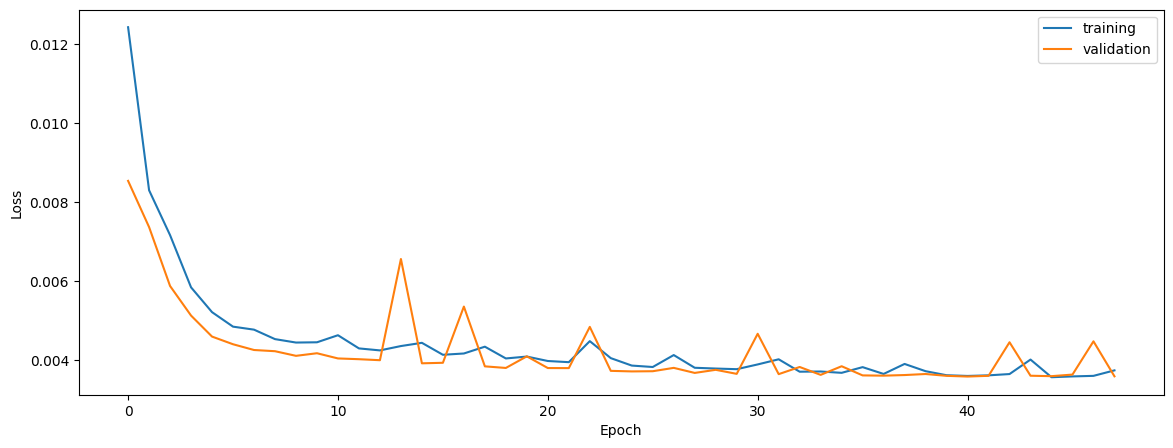

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7995827558511963
0.7877133226046054
0.7885023291884233


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7995827558511963
0.7877133226046054
0.7885023291884233


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8029703838385573
0.788010708805221
0.7944738931752113


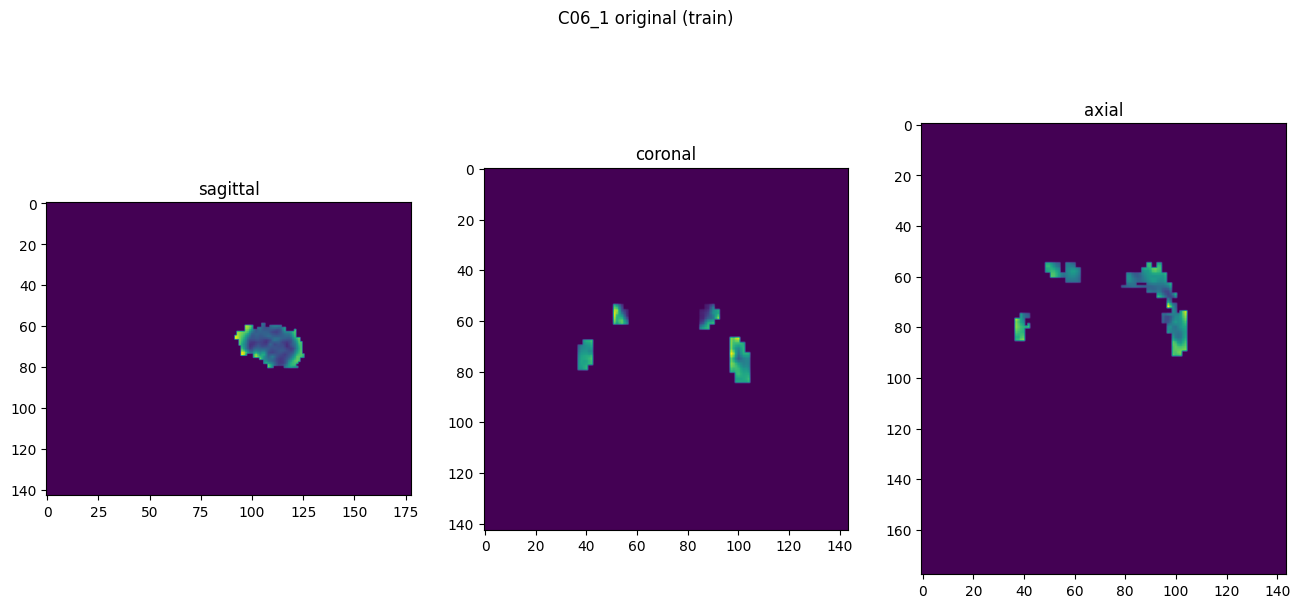

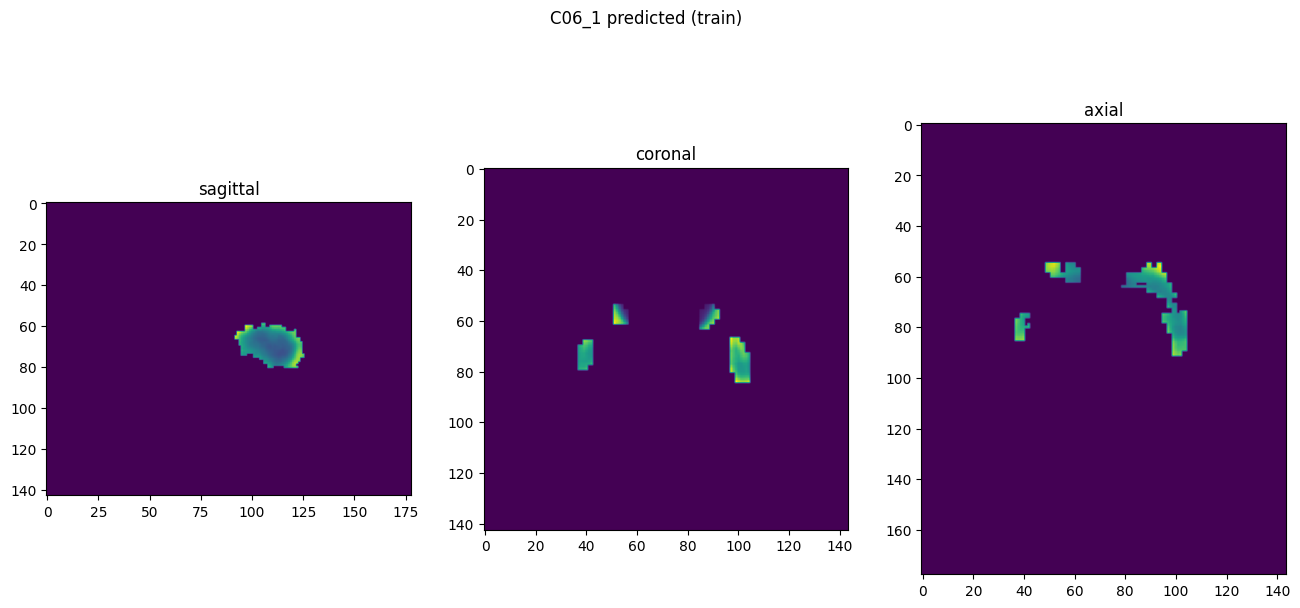

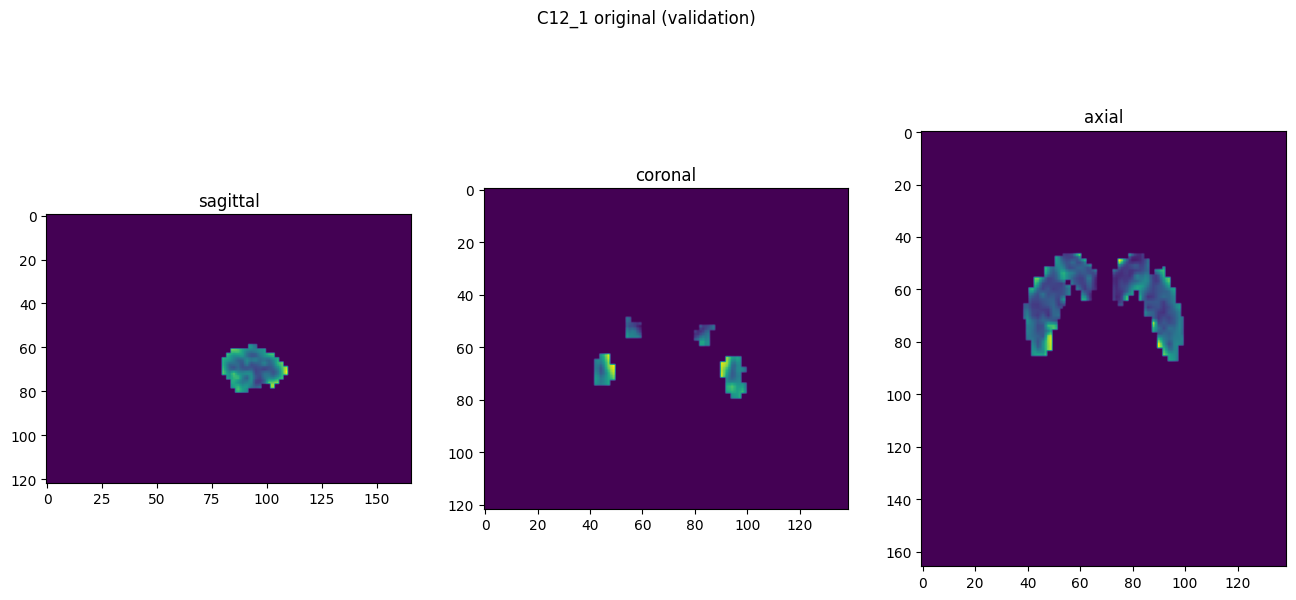

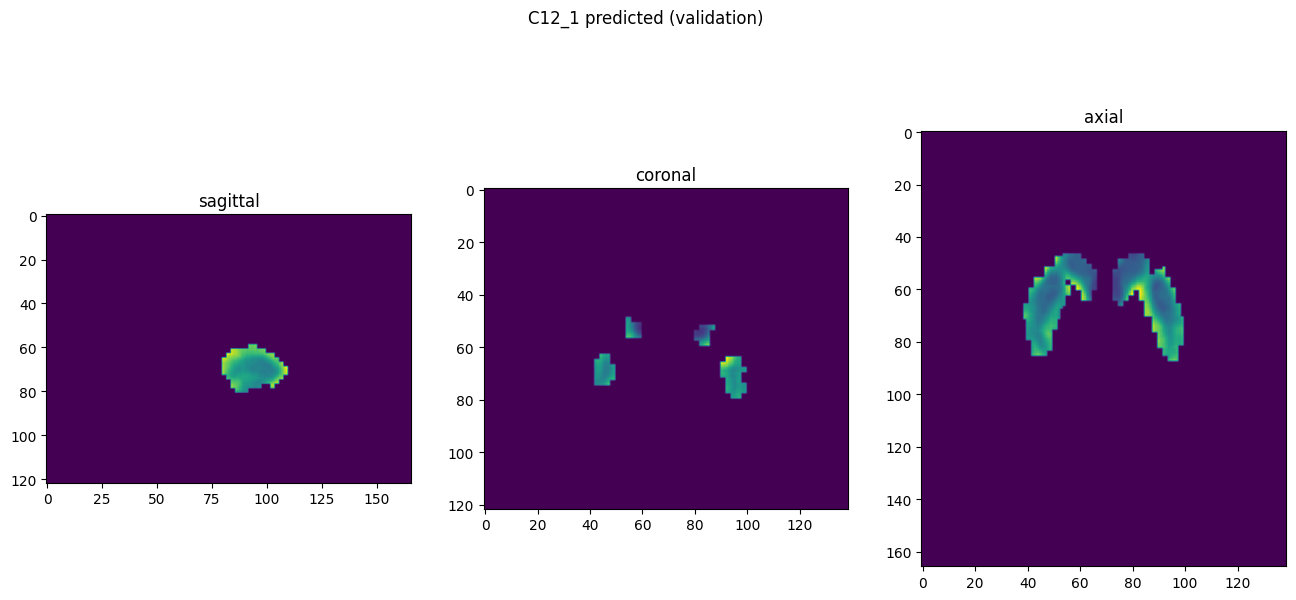

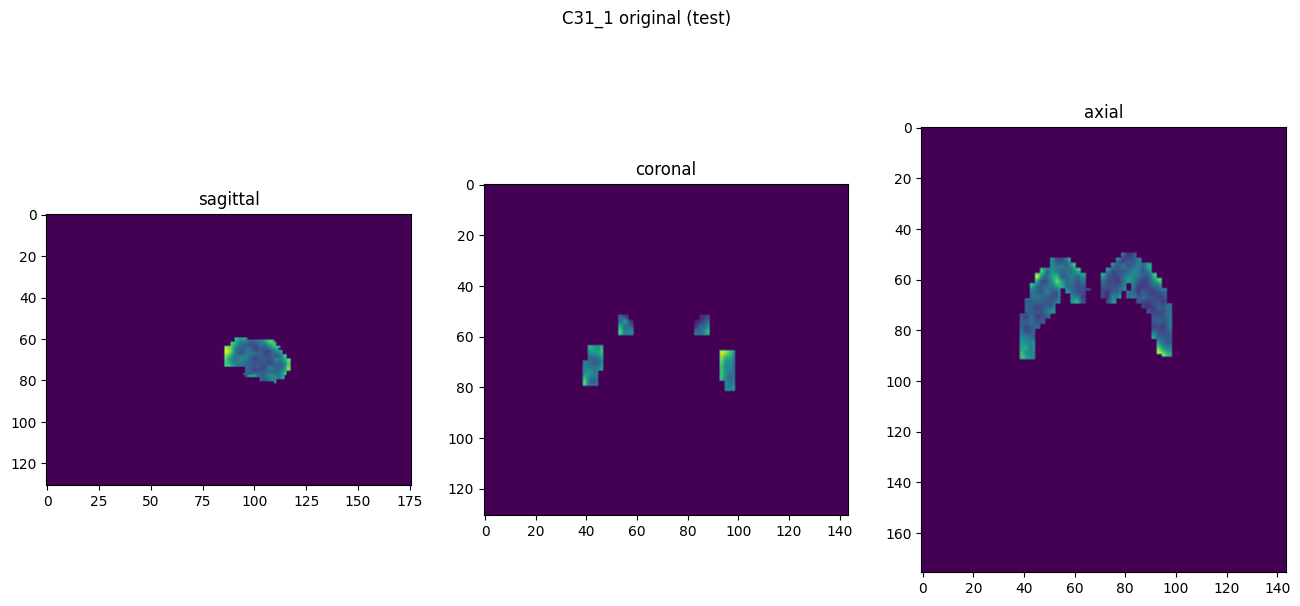

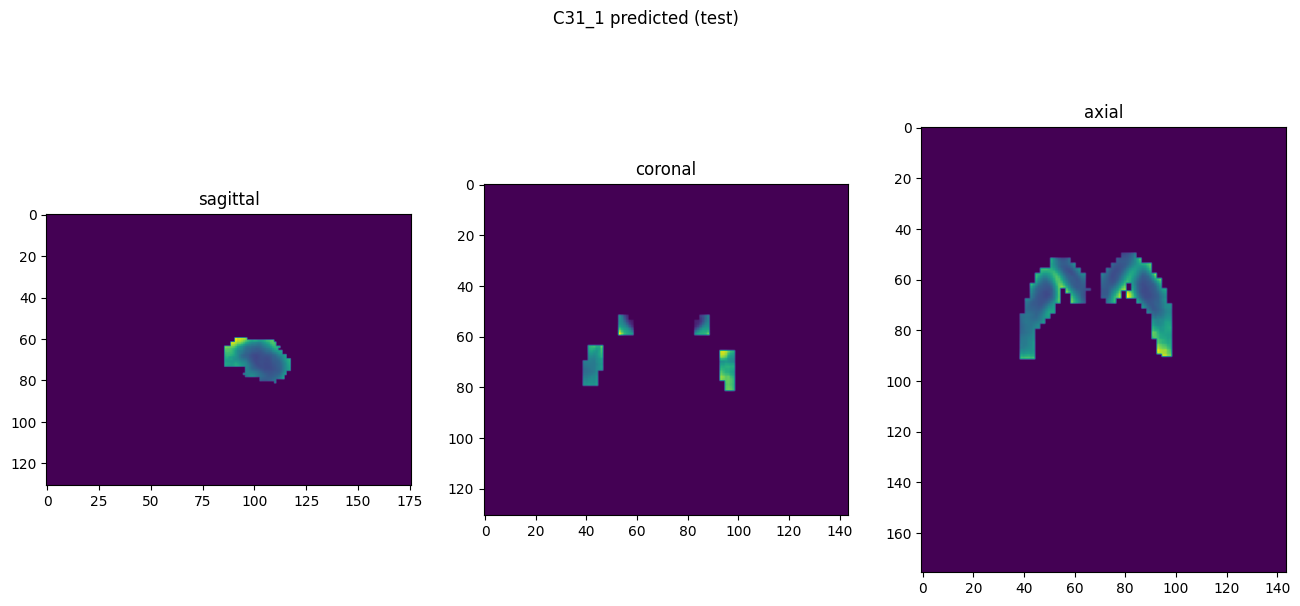

In [10]:
showResults(model, gen, threshold=None, background=False)